In [ ]:
# Copyright 2025 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Vertex AI Model Garden - Deep Dive: Deploy Llama 3.1 and 3.2 with Hex-LLM
## A Comprehensive Deployment Tutorial

<table><tbody><tr>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fvertex-ai-samples%2Fmain%2Fnotebooks%2Fcommunity%2Fmodel_garden%2Fmodel_garden_hexllm_deep_dive_tutorial.ipynb">
      <img alt="Google Cloud Colab Enterprise logo" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" width="32px"><br> Run in Colab Enterprise
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/community/model_garden/model_garden_hexllm_deep_dive_tutorial.ipynb">
      <img alt="GitHub logo" src="https://github.githubassets.com/assets/GitHub-Mark-ea2971cee799.png" width="32px"><br> View on GitHub
    </a>
  </td>
</tr></tbody></table>

## Overview

This notebook provides an in-depth, step-by-step tutorial for deploying Llama 3.1 and 3.2 models using **[Hex-LLM](https://cloud.google.com/vertex-ai/generative-ai/docs/open-models/use-hex-llm)** on TPUs via Vertex AI Model Garden.
**Hex-LLM** is a Google Cloud tool specifically designed for the efficient serving of LLMs on Cloud TPUs (Tensor Processing Units).

### Objective

By the end of this notebook, you will have a thorough understanding of how to:
* Setup Vertex AI environment for endpoint deployment.
* Obtain and setup a Hugging Face Token.
* Configure and Deploy a Llama 3 model with HexLLM on TPU.
* Run inference using both Raw Predict and Chat Completion routes.
* Cleanup the environment.

### Costs

This tutorial uses billable components of Google Cloud:

* Vertex AI (Endpoints)
* Cloud Storage
* Cloud TPU

Learn about [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing), [Cloud Storage pricing](https://cloud.google.com/storage/pricing), [Cloud TPU pricing](https://cloud.google.com/tpu/pricing), and use the [Pricing Calculator](https://cloud.google.com/products/calculator/) to generate a cost estimate based on your projected usage.

## Before you begin

In [ ]:
# @title Request for TPU quota

# @markdown This tutorial defaults to using `ct5lp-hightpu-1t` (1 TPU v5e chip) for deployment, suitable for smaller models (e.g., ~1B parameters).
# @markdown However, the deployment code is configurable for various model sizes and TPU topologies. For example:
# @markdown - **~1B models:** Typically use **1 core** with machine type `ct5lp-hightpu-1t`.
# @markdown - **~8B models:** Can use **4 cores** with machine type `ct5lp-hightpu-4t`.
# @markdown - **Larger models (e.g., up to ~30-40B):** Can utilize **8 cores** with machine type `ct5lp-hightpu-8t`.
# @markdown - **~70B models:** Would typically require **16 cores** (e.g., by configuring two `ct5lp-hightpu-8t` in a suitable multi-host setup, or a larger dedicated TPU slice if available and supported by the deployment method).
# @markdown
# @markdown By default, the quota for TPU deployment `Custom model serving TPU v5e cores per region` is 4. This will be lifted to 16 in the future.
# @markdown Verify that you have the appropriate TPU quota for your chosen configuration (e.g., 1, 4, 8, or 16 cores) in the selected region.
# @markdown You can request for higher TPU quota following the instructions at ["Request a higher quota"](https://cloud.google.com/docs/quota/view-manage#requesting_higher_quota).

In [ ]:
# @title Setup Google Cloud project and Coud Storage

# @markdown 1. [Make sure that billing is enabled for your project](https://cloud.google.com/billing/docs/how-to/modify-project).

# @markdown 2. **[Optional]** [Create a Cloud Storage bucket](https://cloud.google.com/storage/docs/creating-buckets) for storing experiment outputs.
# @markdown Set the BUCKET_URI for the experiment environment.
# @markdown The specified Cloud Storage bucket (`BUCKET_URI`) should be located in the same region as where the notebook is running.
# @markdown If not set, a unique GCS bucket will be created automatically for this notebook.
BUCKET_URI = "gs://"  # @param {type:"string"}

# @markdown 3. **[Optional]** Set the Region.  If not set, the region will be configured automatically based on the environment.
REGION = ""  # @param {type:"string"}

# ==================================================
# INSTALL AND IMPORT PACKAGES
# ==================================================

# Clone samples repo for utils.
! git clone https://github.com/GoogleCloudPlatform/vertex-ai-samples.git

import datetime
import importlib
import os
import uuid
from typing import Tuple

from google.cloud import aiplatform

common_util = importlib.import_module(
    "vertex-ai-samples.community-content.vertex_model_garden.model_oss.notebook_util.common_util"
)

models, endpoints = {}, {}
use_dedicated_endpoint = (
    False  # Dedicated endpoint for HexLLM not supported via this SDK method yet.
)

# ==================================================
# CONFIGURE PROJECT, REGION, BUCKET, SERVICES
# ==================================================

# Get the default cloud project id if not set.
PROJECT_ID = os.environ["GOOGLE_CLOUD_PROJECT"]

# Get the default region for launching jobs if not set.
if not REGION:
    REGION = os.environ.get("GOOGLE_CLOUD_REGION")

# Enable the Vertex AI API and Compute Engine API, if not already.
print("Enabling Vertex AI API and Compute Engine API.")
! gcloud services enable aiplatform.googleapis.com compute.googleapis.com --project {PROJECT_ID}

# Configure GCS Bucket.
now = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
BUCKET_NAME = "/".join(BUCKET_URI.split("/")[:3])

if BUCKET_URI is None or BUCKET_URI.strip() == "" or BUCKET_URI == "gs://":
    BUCKET_URI = f"gs://{PROJECT_ID}-tmp-{now}-{str(uuid.uuid4())[:4]}"
    BUCKET_NAME = "/".join(BUCKET_URI.split("/")[:3])
    print(f"Creating a new GCS Bucket: {BUCKET_URI}")
    ! gsutil mb -l {REGION} {BUCKET_URI}
else:
    assert BUCKET_URI.startswith("gs://"), "BUCKET_URI must start with `gs://`."
    shell_output = ! gsutil ls -Lb {BUCKET_NAME} | grep "Location constraint:" | sed "s/Location constraint://"
    bucket_region = shell_output[0].strip().lower()
    if bucket_region != REGION.lower():
        raise ValueError(
            "Bucket region %s is different from notebook region %s"
            % (bucket_region, REGION)
        )
print(f"Using this GCS Bucket: {BUCKET_URI}")

STAGING_BUCKET = os.path.join(BUCKET_URI, "temporal")
MODEL_BUCKET = os.path.join(BUCKET_URI, "llama3_hexllm_models")

# ==================================================
# INITIALIZE VERTEX AI AND PERMISSIONS
# ==================================================

# Initialize Vertex AI API.
print("Initializing Vertex AI API.")
aiplatform.init(project=PROJECT_ID, location=REGION, staging_bucket=STAGING_BUCKET)

# Gets the default SERVICE_ACCOUNT.
shell_output = ! gcloud projects describe $PROJECT_ID
project_number = shell_output[-1].split(":")[1].strip().replace("'", "")
SERVICE_ACCOUNT = f"{project_number}-compute@developer.gserviceaccount.com"
print("Using this default Service Account:", SERVICE_ACCOUNT)

# Provision permissions to the SERVICE_ACCOUNT with the GCS bucket
! gcloud config set project $PROJECT_ID
! gsutil iam ch serviceAccount:{SERVICE_ACCOUNT}:roles/storage.admin $BUCKET_NAME
! gcloud projects add-iam-policy-binding --no-user-output-enabled {PROJECT_ID} --member=serviceAccount:{SERVICE_ACCOUNT} --role="roles/storage.admin"
! gcloud projects add-iam-policy-binding --no-user-output-enabled {PROJECT_ID} --member=serviceAccount:{SERVICE_ACCOUNT} --role="roles/aiplatform.user"

### Using Hugging Face with Meta Llama 3.1 and Hex-LLM for Efficient Model Serving

Meta’s Llama 3 collection provide a range of multilingual large language models (LLMs) designed for high-quality text generation across various use cases. These models are pretrained and instruction-tuned, excelling in tasks like multilingual dialogue, summarization, and agentic retrieval. For efficient deployment of these models, Hex-LLM is based on open source projects with Google's own optimizations for XLA and Cloud TPU. Hex-LLM achieves high throughput and low latency when serving frequently used LLMs like Llama 3.

The Llama 3 is a **gated** model. You need to agree to share your contact information to access the model.

<img src="https://cloud.google.com/static/vertex-ai/generative-ai/docs/open-models/vllm/images/meta_llama_agreement.png">

### HuggingFace User Access Tokens

This tutorial requires a read access token from the Hugging Face Hub to access the necessary resources. Please follow these steps to set up your authentication:

 #### Generate a Read Access Token:
- Navigate to your [Hugging Face account settings](https://huggingface.co/settings/tokens).
- Create a new token, assign it the Read role, and save the token securely.

<img src="https://cloud.google.com/static/vertex-ai/generative-ai/docs/open-models/vllm/images/access_token_settings_link.png">

#### Utilize the Token:
Use the generated token to authenticate and access public or private repositories as needed for the tutorial.
This setup ensures you have the appropriate level of access without unnecessary permissions. These practices enhance security and prevent accidental token exposure. For more information on setting up access tokens, visit this [page](https://huggingface.co/docs/hub/en/security-tokens).

Make sure to enable Read access. Once the access token has been created, Please be cautious with your Hugging Face access token. Avoid sharing or exposing it publicly or online. When you set your token as an environment variable during deployment, it remains private to your project. Vertex AI ensures its security by preventing other users from accessing your models and endpoints.

<img src="https://cloud.google.com/static/vertex-ai/generative-ai/docs/open-models/vllm/images/manage_access_token.png">

For more information on protecting your access token, please refer to the [Hugging Face Access Tokens - Best Practices](https://huggingface.co/docs/hub/en/security-tokens#best-practices).

In [ ]:
# @title Set Hugging Face Token
# @markdown This tutorial requires a read access token from the Hugging Face Hub.
# @markdown 1. Navigate to your Hugging Face account settings and create a new token with the `Read` role.
# @markdown 2. Paste the token below.
# @markdown Vertex AI ensures security by preventing other users from accessing your models and endpoints that use the token.
# @markdown Avoid sharing or exposing the token publicly.

# IMPORTANT: Enter your Hugging Face Read Token here.
HF_TOKEN = ""  # @param {type:"string"}

if HF_TOKEN.strip() == "":
    print(
        "WARNING: Hugging Face token is not set. Deployment may fail if the model requires it."
    )
else:
    print("Hugging Face token set.")

## Hex-LLM Deep Dive: Efficient LLM Serving on TPUs

### Introduction
Large Language Models (LLMs) have significantly impacted a variety of fields, but their efficient deployment and serving can be challenging. Hex-LLM is a Google Cloud tool designed to address these challenges by streamlining and optimizing LLM serving on Cloud TPUs.

### Key Challenges in LLM Inference
* **Speed**: The responsiveness of an LLM is crucial for a positive user experience, and delays can be detrimental.
* **Cost**: Operating large LLM models can be financially demanding, making it important to minimize the cost per token generated.

### How Hex-LLM Works
TPUs are specialized hardware accelerators designed to enhance the performance of machine learning workloads, especially matrix computations, which are central to LLMs. Hex-LLM leverages several techniques to optimize LLM serving on TPUs:

* **XLA Compiler**: Hex-LLM uses the XLA (Accelerated Linear Algebra) compiler to translate the computational graph of the LLM into optimized TPU machine code. XLA performs advanced optimizations, including tiling matrix multiplications for efficient execution on the TPU's Matrix Multiply Unit (MXU). This results in efficient computation, enhancing performance.
* **Continuous Batching**: To maximize TPU utilization and memory efficiency, Hex-LLM employs continuous batching. This technique groups tokens from multiple requests and processes them together. Instead of waiting for a full batch, new requests are scheduled as soon as slots are available, improving throughput and reducing idle time.
* **PagedAttention**: To address the memory requirements associated with processing large LLMs, Hex-LLM utilizes PagedAttention. This method partitions the key-value (KV) cache into smaller, manageable blocks or 'pages,' similar to how operating systems handle virtual memory. By dynamically allocating memory and only loading necessary pages, PagedAttention reduces memory fragmentation and improves efficiency, especially for long sequences.
* **Flash Attention and Sparse Flash (SplaSH) Attention**: Hex-LLM also supports **Flash Attention** and **Sparse Flash (SplaSH) Attention**. Flash Attention is a method that restructures the attention computation to reduce memory transfers, leading to faster training and inference. It loads data once and performs computations in blocks, optimizing GPU memory usage. Sparse Flash Attention further enhances efficiency by exploiting sparsity in attention patterns.
* **Parallelism**: Hex-LLM distributes the workload across multiple TPU cores, enabling simultaneous processing and improved efficiency. Different forms of parallelism, such as data and tensor parallelism may be employed to optimize performance based on the model architecture and hardware configuration.


Hex-LLM is accessible through Vertex AI Model Garden, promoting transparency and community contributions.

### Performance and Features
Hex-LLM is designed for:

* **High Throughput**: It achieves high throughput rates, enabling faster processing.
* **Cost-Effectiveness**: Aims to demonstrate lower cost per token compared to alternative solutions.
* **Dynamic LoRA Loading**: Supports dynamic loading of LoRA (low-rank adaptation) adapters, allowing for on-the-fly customization of LLMs without incurring downtime.
* **Quantization**: Utilizes quantization techniques to reduce model size and memory consumption while maintaining performance levels.
* **Hugging Face Compatibility**: Compatibility with Hugging Face provides access to a wide range of pre-trained LLMs.

### Getting Started Approaches
You can use Hex-LLM via Vertex AI Model Garden in several ways:

1.  **Playground**: Send requests to a pre-deployed endpoint directly in the model card UI.
2.  **One-Click Deployment**: Use the `Deploy` button on a model card, select a Cloud TPU v5e machine type, and click `Deploy` to create the model upload and endpoint.
3.  **Colab Enterprise Notebook**: Use the Vertex AI SDK for Python (as shown in this notebook) for maximum flexibility and customization when deploying.

## Deploy Llama 3 with Hex-LLM

In [ ]:
# @title Deploy

# @markdown This section uploads the selected Llama 3 model to Model Registry and deploys it to a Vertex AI Endpoint using the Hex-LLM container.
# @markdown Deployment takes approximately 15 minutes to 1 hour, depending on the model size.

# @markdown --- MODEL AND REGION SELECTION ---
# @markdown Select a Llama 3 model variant identifier (must match a folder name in your GCS bucket created earlier).
MODEL_ID_SUFFIX = "Llama-3.1-8B-Instruct"  # @param ["Llama-3.2-1B-Instruct", "Llama-3.2-1B", "Llama-3.1-8B-Instruct", "Llama-3.1-8B" , "Llama-3.1-70B-Instruct", "Llama-3.1-70B"] {allow-input: true}

# @markdown Select the Region for TPU Deployment.
TPU_DEPLOYMENT_REGION = "us-west1"  # @param ["us-west1"]

# @markdown --- TPU HARDWARE CONFIGURATION ---
# @markdown Select the machine type and TPU topology. Ensure you have quota.
# @markdown Use 1 core for 1B models, 4 cores for 8B, 16 for 70B, etc.
machine_type = "ct5lp-hightpu-4t"  # @param ["ct5lp-hightpu-1t", "ct5lp-hightpu-4t", "ct5lp-hightpu-8t"] {allow-input: true}

# @markdown --- HEX-LLM SERVER PARAMETERS ---
# @markdown Configure Hex-LLM runtime parameters.
# @markdown See documentation: https://cloud.google.com/vertex-ai/generative-ai/docs/open-models/use-hex-llm#config-server

# @markdown Fraction of HBM memory allocated for KV cache after model loading. (0.0-1.0)
hbm_utilization_factor = 0.8  # @param {type:"number"}
# @markdown Maximum number of running sequences in a continuous batch.
max_running_seqs = 256  # @param {type:"integer"}
# @markdown Maximum context length (tokens) for a request.
max_model_len = 4096  # @param {type:"integer"}

# @markdown --- ENDPOINT CONFIGURATION ---
min_replica_count = 1  # @param {type:"integer"}
max_replica_count = 1  # @param {type:"integer"}

# ==================================================
# DERIVED VALUES AND QUOTA CHECK
# ==================================================
hf_model_id = f"meta-llama/{MODEL_ID_SUFFIX}"

# Find the latest HexLLM docker image (Check Artifact Registry for updates if needed).
HEXLLM_DOCKER_URI = "us-docker.pkg.dev/vertex-ai-restricted/vertex-vision-model-garden-dockers/hex-llm-serve:20241210_2323_RC00"

# Infer tpu_count from machine_type, assuming ct5lp-hightpu-Xt format
try:
    tpu_count = int(machine_type.split("-")[-1].replace("t", ""))
except ValueError:
    print(
        f"Could not infer tpu_count from machine_type {machine_type}. Defaulting to 1. Please check machine_type."
    )
    tpu_count = 1


if "1B" in MODEL_ID_SUFFIX:
    tpu_count = 1
    tpu_topo = "1x1"
if "8B" in MODEL_ID_SUFFIX:
    tpu_count = 4
    tpu_topo = "1x4"
elif "70B" in MODEL_ID_SUFFIX:
    tpu_count = 16
    tpu_topo = "4x4"
else:
    raise ValueError(f"Unsupported MODEL_ID: {MODEL_ID_SUFFIX}")

tensor_parallel_size = tpu_count
tpu_type = "TPU_V5e"

print(f"Deploying Model: {MODEL_ID_SUFFIX}")
print(f"  Quota check region: {TPU_DEPLOYMENT_REGION}")
print(f"  Machine Type: {machine_type}")
print(f"  TPU Count: {tpu_count}")
print(f"  Tensor Parallel Size: {tensor_parallel_size}")

common_util.check_quota(
    project_id=PROJECT_ID,
    region=TPU_DEPLOYMENT_REGION,
    accelerator_type=tpu_type,
    accelerator_count=tpu_count,
    is_for_training=False,
)


# ==================================================
# DEPLOYMENT FUNCTION DEFINITION
# ==================================================
def deploy_model_hexllm(
    model_name: str,
    model_id: str,  # GCS URI for the model artifacts
    service_account: str,
    hf_model_id: str,  # Hugging Face ID, e.g. meta-llama/Llama-3.2-1B
    tensor_parallel_size: int = 1,
    data_parallel_size: int = 1,
    machine_type: str = "ct5lp-hightpu-1t",
    tpu_topology: str = "1x1",
    hbm_utilization_factor: float = 0.6,
    max_running_seqs: int = 256,
    max_model_len: int = 4096,
    endpoint_id: str = "",
    min_replica_count: int = 1,
    max_replica_count: int = 1,
    use_dedicated_endpoint: bool = False,
    deployment_region: str = "us-west1",
) -> Tuple[aiplatform.Model, aiplatform.Endpoint]:
    """Deploys models with Hex-LLM on TPU in Vertex AI."""

    # Create Endpoint
    endpoint = aiplatform.Endpoint.create(
        display_name=f"{model_name}-endpoint",
        location=deployment_region,
        dedicated_endpoint_enabled=use_dedicated_endpoint,
    )

    # Configure HexLLM Server Arguments
    num_hosts = int(tpu_topology.split("x")[0])
    hexllm_args = [
        "--host=0.0.0.0",
        "--port=7080",
        f"--model={model_id}",
        f"--data_parallel_size={data_parallel_size}",
        f"--tensor_parallel_size={tensor_parallel_size}",
        f"--num_hosts={num_hosts}",
        f"--hbm_utilization_factor={hbm_utilization_factor}",
        f"--max_running_seqs={max_running_seqs}",
        f"--max_model_len={max_model_len}",
    ]

    # Configure Environment Variables, including HF_TOKEN if provided
    env_vars = {
        "MODEL_ID": hf_model_id,
        "HEX_LLM_LOG_LEVEL": "info",
        "DEPLOY_SOURCE": "notebook",
    }
    try:
        if HF_TOKEN:
            env_vars.update({"HF_TOKEN": HF_TOKEN})
    except NameError:  # HF_TOKEN may not be defined
        pass

    # Upload Model
    model = aiplatform.Model.upload(
        display_name=model_name,
        serving_container_image_uri=HEXLLM_DOCKER_URI,
        serving_container_command=["python", "-m", "hex_llm.server.api_server"],
        serving_container_args=hexllm_args,
        serving_container_ports=[7080],
        serving_container_predict_route="/generate",
        serving_container_health_route="/ping",
        serving_container_environment_variables=env_vars,
        serving_container_shared_memory_size_mb=(16 * 1024),  # 16 GB
        serving_container_deployment_timeout=7200,  # 2 hours
        location=deployment_region,
    )

    print(f"Deploying model {model.display_name} to endpoint {endpoint.display_name}")

    # Deploy Model
    model.deploy(
        endpoint=endpoint,
        machine_type=machine_type,
        tpu_topology=tpu_topology if num_hosts > 1 else None,
        deploy_request_timeout=1800,  # 30 minutes
        service_account=service_account,
        min_replica_count=min_replica_count,
        max_replica_count=max_replica_count,
    )

    print("Model deployment finished.")
    return model, endpoint


# ==================================================
# CALL DEPLOYMENT
# ==================================================

models["hexllm_tpu"], endpoints["hexllm_tpu"] = deploy_model_hexllm(
    model_name=common_util.get_job_name_with_datetime(
        prefix=f"{MODEL_ID_SUFFIX}-hexllm"
    ),
    model_id=hf_model_id,
    service_account=SERVICE_ACCOUNT,
    hf_model_id=hf_model_id,
    tensor_parallel_size=tensor_parallel_size,
    machine_type=machine_type,
    tpu_topology=tpu_topo,
    hbm_utilization_factor=hbm_utilization_factor,
    max_running_seqs=max_running_seqs,
    max_model_len=max_model_len,
    min_replica_count=min_replica_count,
    max_replica_count=max_replica_count,
    use_dedicated_endpoint=use_dedicated_endpoint,
    deployment_region=TPU_DEPLOYMENT_REGION,
)

print("Deployment process initiated.")
# @markdown You can check the progress in the Google Cloud Console: Vertex AI -> Online Prediction -> Endpoints.

In [ ]:
# @title Raw Predict

# @markdown Once deployment succeeds, send requests to the endpoint with text prompts.
# @markdown The first few queries to a fresh endpoint might take longer.
# @markdown You can optionally integrate moderation using the [Moderate text documentation](https://cloud.google.com/natural-language/docs/moderating-text).

# Loads an existing endpoint instance using the endpoint name:
# - Using `endpoint_name = endpoint.name` allows us to get the
#   endpoint name of the endpoint `endpoint` created in the cell
#   above.
# - Alternatively, you can set `endpoint_name = "1234567890123456789"` to load
#   an existing endpoint with the ID 1234567890123456789.
# You may uncomment the code below to load an existing endpoint.

# endpoint_name = ""  # @param {type:"string"}
# aip_endpoint_name = (
#     f"projects/{PROJECT_ID}/locations/{REGION}/endpoints/{endpoint_name}"
# )
# vendpoint = aiplatform.Endpoint(aip_endpoint_name)

# @markdown --- Prediction Parameters ---
prompt = "What is a car?"  # @param {type: "string"}

# @markdown If you encounter 503 Service Unavailable errors, try reducing max_tokens.
max_tokens = 100  # @param {type: "integer"}
temperature = 0.8  # @param {type: "number"}
top_p = 1.0  # @param {type: "number"}
top_k = 1  # @param {type: "integer"}

# Overrides parameters for inferences.
instances = [
    {
        "prompt": prompt,
        "max_tokens": max_tokens,
        "temperature": temperature,
        "top_p": top_p,
        "top_k": top_k,
    },
]

# Send the request
print(f"Sending Prompt: {prompt}")
response = endpoints["hexllm_tpu"].predict(
    instances=instances, use_dedicated_endpoint=use_dedicated_endpoint
)

print("--- RESPONSE ---")
for prediction in response.predictions:
    print(prediction)

In [ ]:
# @title Chat Completion Predict (OpenAI SDK Compatible)

# @markdown Use the OpenAI-compatible Chat Completions route for conversational interactions.

# @markdown Install the required packages.
! pip install -qU openai google-auth requests

In [ ]:
# @title Run Chat Completion

# @markdown --- Chat Parameters ---
user_message = "What is a plane?"  # @param {type: "string"}
max_tokens = 50  # @param {type: "integer"}
temperature = 1.0  # @param {type: "number"}

import google.auth
import google.auth.transport.requests
import openai

# --- Authentication and Client Setup ---
creds, project = google.auth.default()
auth_req = google.auth.transport.requests.Request()
creds.refresh(auth_req)

# --- Construct URL and Instantiate Client ---
endpoint_region = endpoints["hexllm_tpu"].location
ENDPOINT_RESOURCE_NAME = endpoints["hexllm_tpu"].resource_name
BASE_URL = f"https://{endpoint_region}-aiplatform.googleapis.com/v1beta1/{ENDPOINT_RESOURCE_NAME}"

client = openai.OpenAI(base_url=BASE_URL, api_key=creds.token)

# --- Send Chat Request ---
print(f"Sending Message: {user_message}")

model_response = client.chat.completions.create(
    model="hexllm",  # Model name is ignored by Vertex endpoint, but required by SDK.
    messages=[{"role": "user", "content": user_message}],
    temperature=temperature,
    max_tokens=max_tokens,
)

print("--- RESPONSE --- ")
print(model_response)

print("\n--- MESSAGE CONTENT --- \n")
try:
    print(model_response.choices[0].message.content)
except Exception as e:
    print(f"Could not extract message content: {e}")

## Clean up resources

In [ ]:
# @title Delete the models and endpoints

# @markdown  Delete the experiment models and endpoints to recycle the resources
# @markdown  and avoid unnecessary continuous charges that may incur.

# Undeploy model and delete endpoint.
for endpoint in endpoints.values():
    endpoint.delete(force=True)

# Delete models.
for model in models.values():
    model.delete()

delete_bucket = False  # @param {type:"boolean"}
if delete_bucket:
    ! gsutil -m rm -r $BUCKET_NAME

### Debugging Common Bugs and Issues

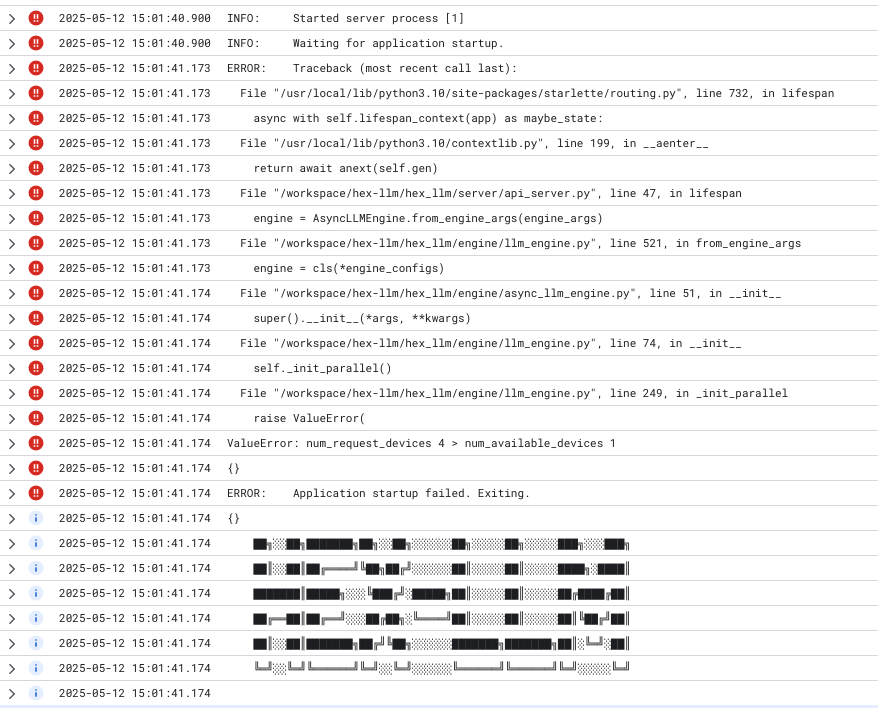

### ValueError: num_request_devices > num_available_devices

ValueError: num_request_devices 4 > num_available_devices 1.

To resolve this problem, make sure the the correct machine is selected for the correct number of TPU cores.